In [240]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) #ignore the warning to keep ipython clean

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection, preprocessing
import xgboost as xgb
color = sns.color_palette()

%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', 500)

In [241]:
train = pd.read_csv("Data/train.csv", parse_dates=['timestamp'])
y = train["price_doc"]
ylog = np.log(y)
train = train.drop(["price_doc"], axis=1)
num_train = train.shape[0]

test = pd.read_csv("Data/test.csv", parse_dates=['timestamp'])
data = pd.concat([train, test], axis=0)
print train.shape, test.shape, data.shape

(30471, 291) (7662, 291) (38133, 291)


In [242]:
print np.mean(y), np.median(y)
print np.mean(ylog), np.median(ylog)

7123035.27774 6274411.0
15.6094829642 15.651990174


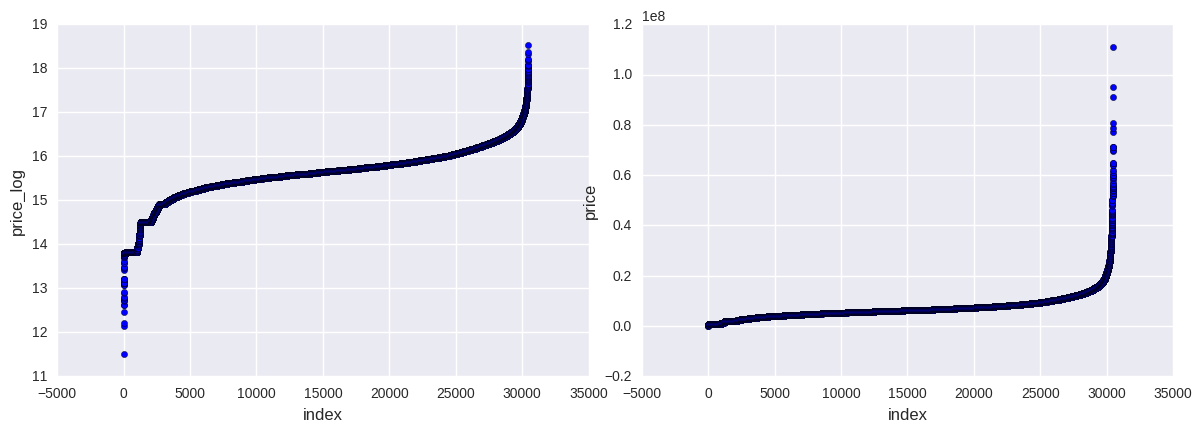

In [243]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
fig.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.94, wspace=0.1)

axs[0].scatter(range(train.shape[0]), np.sort(ylog))
axs[0].set_xlabel('index', fontsize=12)
axs[0].set_ylabel('price_log', fontsize=12)

axs[1].scatter(range(train.shape[0]), np.sort(y))
axs[1].set_xlabel('index', fontsize=12)
axs[1].set_ylabel('price', fontsize=12)


In [244]:
# truncate the extreme values in price_doc #
ulimit = np.percentile(ylog, 99)
llimit = np.percentile(ylog, 1)
#ylog[ylog>ulimit] = ulimit
#ylog[ylog<llimit] = llimit

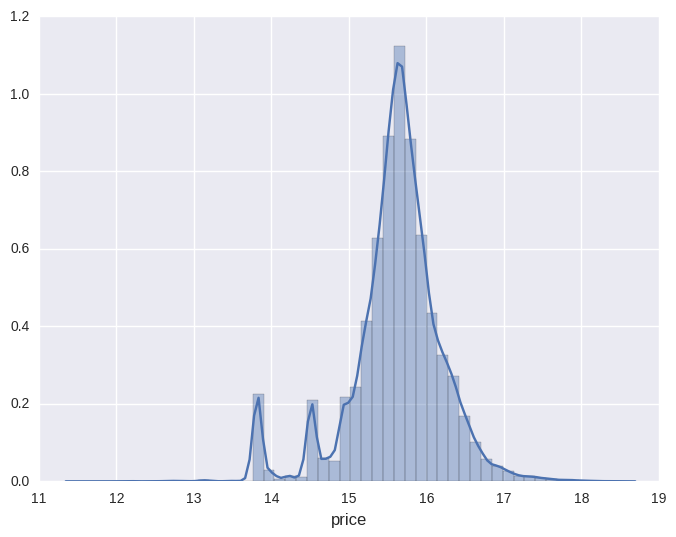

In [245]:
plt.figure(figsize=(8,6))
sns.distplot(ylog, bins=50, kde=True)
plt.xlabel('price', fontsize=12)
plt.show()

In [246]:
data["year"] = data["timestamp"].dt.year
data["month"] = data["timestamp"].dt.month
data["week"] = data["timestamp"].dt.weekofyear # week of year
data["day"] = data["timestamp"].dt.weekday

In [247]:
data["time_month"] = (data['year'] - 2011) * 12 + data["month"]
data["time_week"] = (data['year'] - 2011) * 53 + data["week"]

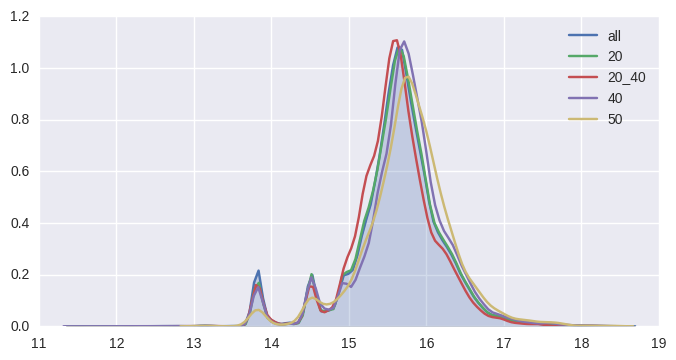

In [248]:
plt.figure(figsize=(8,4))
sns.kdeplot(ylog, shade=True, label="all")

index = (data[:num_train].time_month.values > 20)
sns.kdeplot(ylog[index], shade=False, label="20")

index = (data[:num_train].time_month.values > 20) & (data[:num_train].time_month.values < 40)
sns.kdeplot(ylog[index], shade=False, label="20_40")

index = (data[:num_train].time_month.values > 40)
sns.kdeplot(ylog[index], shade=False, label="40")

index = (data[:num_train].time_month.values > 50)
sns.kdeplot(ylog[index], shade=False, label="50")
plt.legend(loc='best');

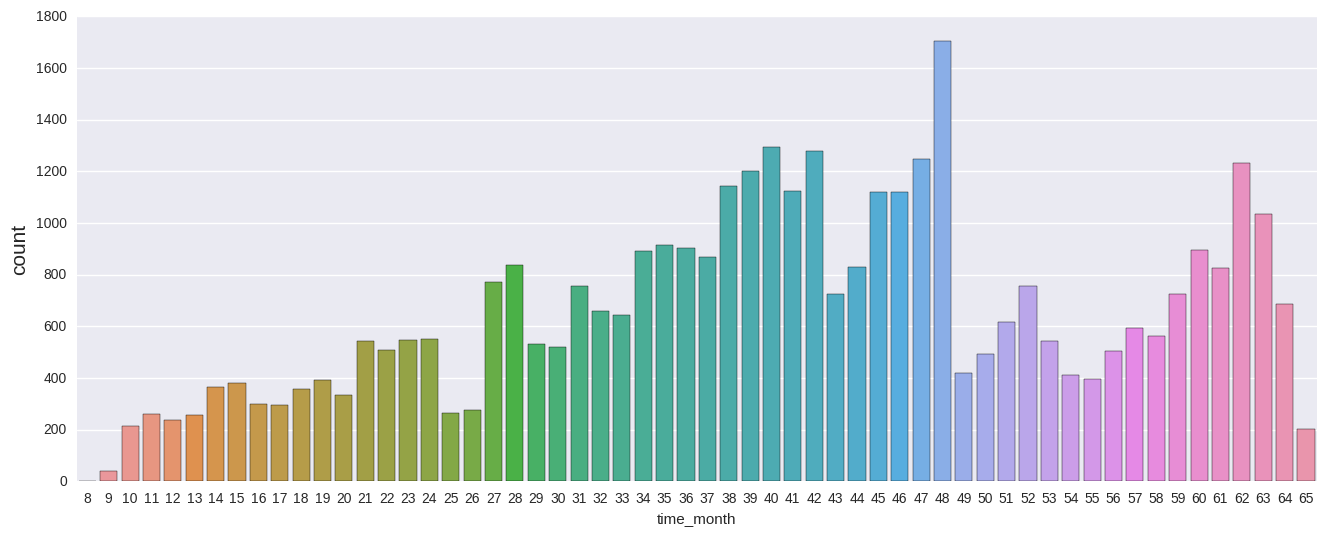

In [249]:
fig, axs = plt.subplots(ncols=1, figsize=(16, 6))
sns.countplot(x = 'time_month', data = data, ax=axs)
axs.set_ylabel('count', fontsize=15)


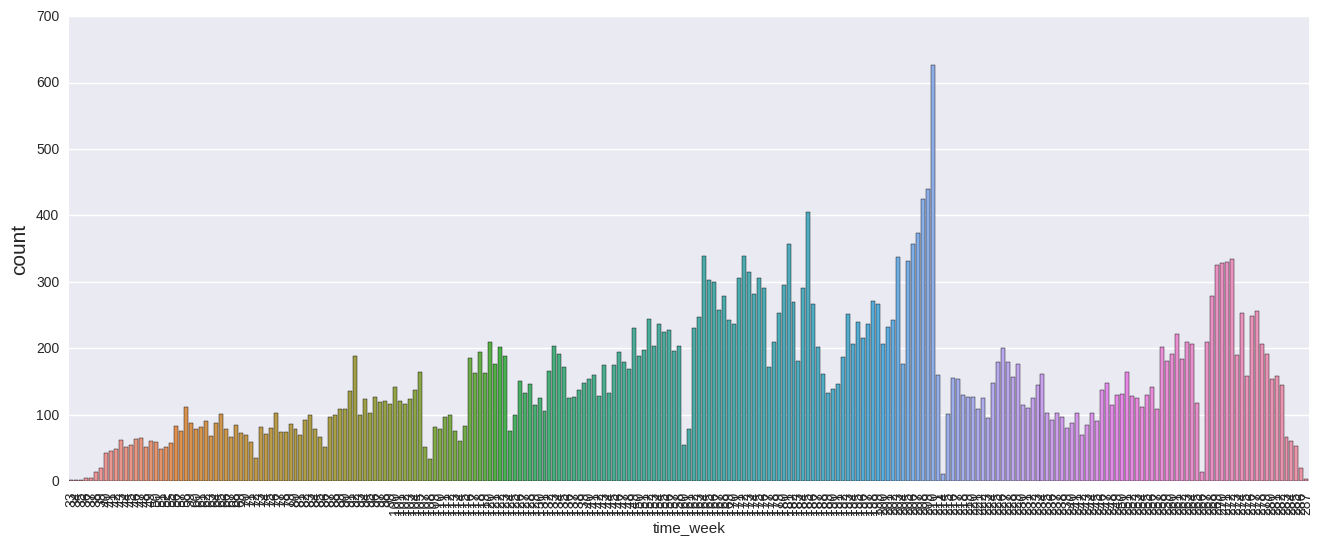

In [250]:
fig, axs = plt.subplots(ncols=1, figsize=(16, 6))
sns.countplot(x = 'time_week', data = data, ax=axs)
axs.set_ylabel('count', fontsize=15)
plt.xticks(rotation=90)
plt.show()

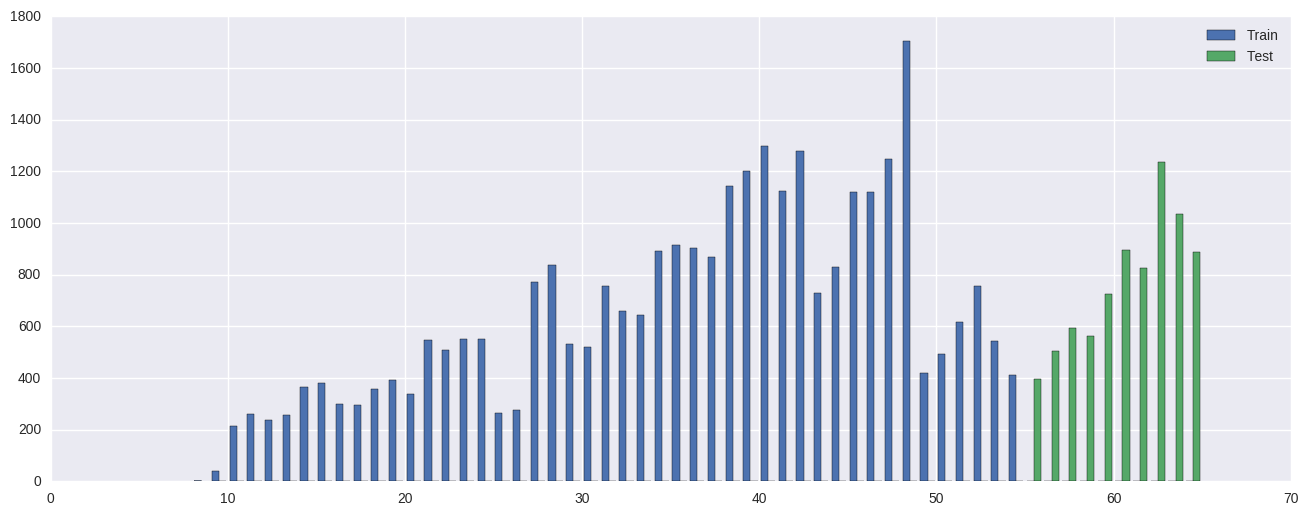

In [251]:
fig, axs = plt.subplots(ncols=1, figsize=(16, 6))
binsize = 57
B=['Train','Test']
t1 = data[:num_train].time_month.values
t2 = data[num_train:].time_month.values
plt.hist([t1, t2] , binsize, histtype='bar', align='mid', range=(8,65), label=B, alpha=1.)
axs.legend()

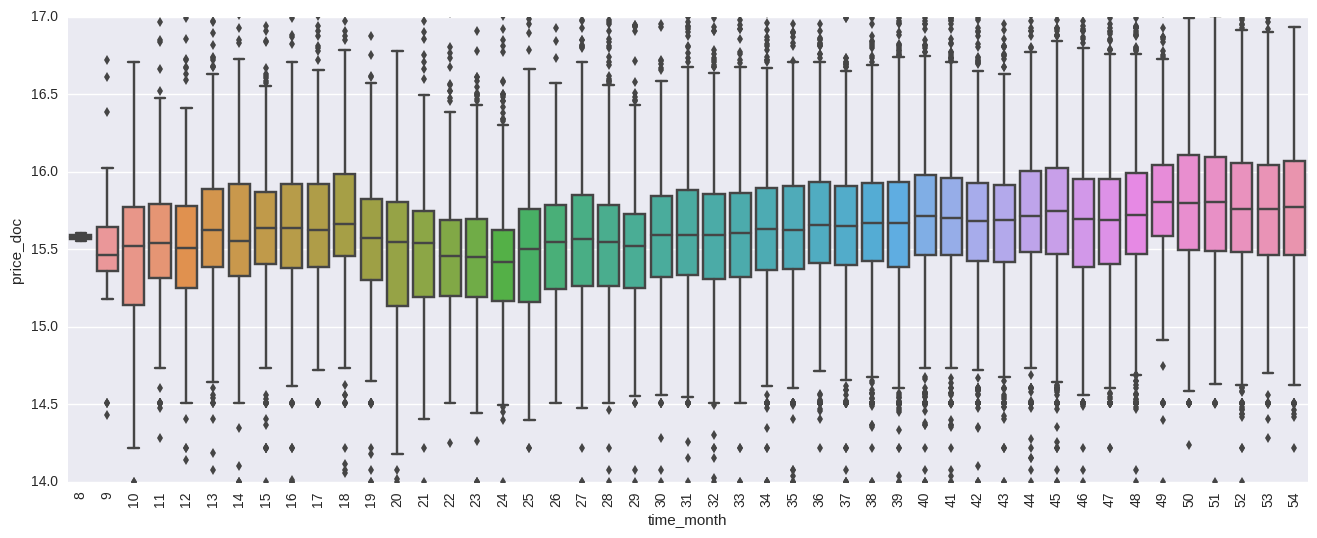

In [252]:
plt.figure(figsize=(16,6))
sns.boxplot(x = "time_month", y = ylog, data = data[:num_train]).set(ylim = (14,17))
plt.xticks(rotation = 90)
plt.show()

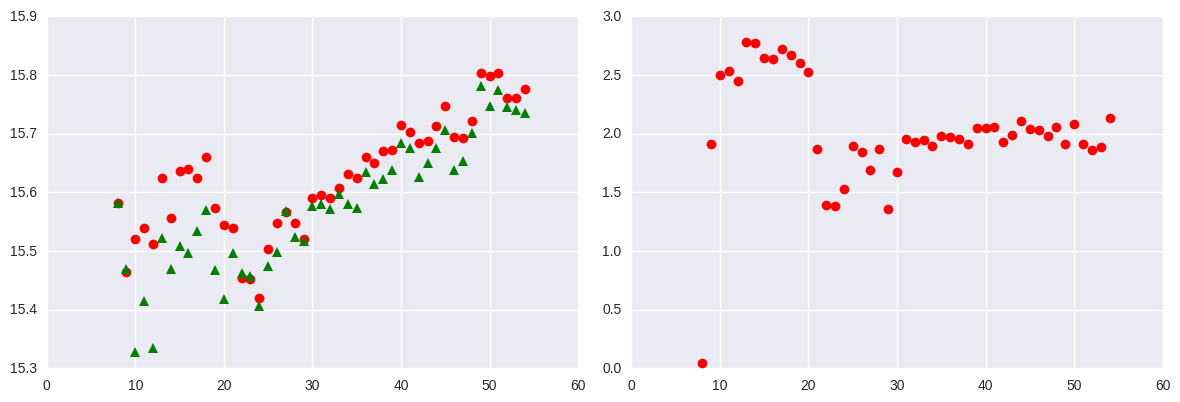

In [253]:
tt = data[:num_train]
tt = tt[["time_month", "time_week"]]
tt['price'] = ylog
tt['time_month'] = tt["time_month"].apply(str)
price_median = tt.groupby('time_month')['price'].aggregate(np.median).reset_index()
price_mean = tt.groupby('time_month')['price'].aggregate(np.mean).reset_index()
price_q1 = tt.groupby('time_month')['price'].aggregate(lambda x: np.percentile(x,5)).reset_index()
price_q3 = tt.groupby('time_month')['price'].aggregate(lambda x: np.percentile(x,95)).reset_index()

price_q1["delta"] = price_q3["price"] - price_q1["price"]


fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
fig.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.94, wspace=0.1)

axs[0].plot(price_median["time_month"], price_median["price"], 'ro',
         price_mean["time_month"], price_mean["price"], 'g^')

axs[1].plot(price_q1["time_month"], price_q1["delta"], 'ro')




In [257]:
print y.mean(), y.median()
print tt['price'].mean(), tt['price'].median()

# read naive xgboost
pred = pd.read_csv("naivexgb.csv")
print pred['price_doc'].mean(), pred['price_doc'].median()
pred['price'] = np.log(pred['price_doc'])
print pred['price'].mean(), pred['price'].median()

7123035.27774 6274411.0
15.6094829642 15.651990174
7498411.58394 6577598.75
15.7396444892 15.6991803046


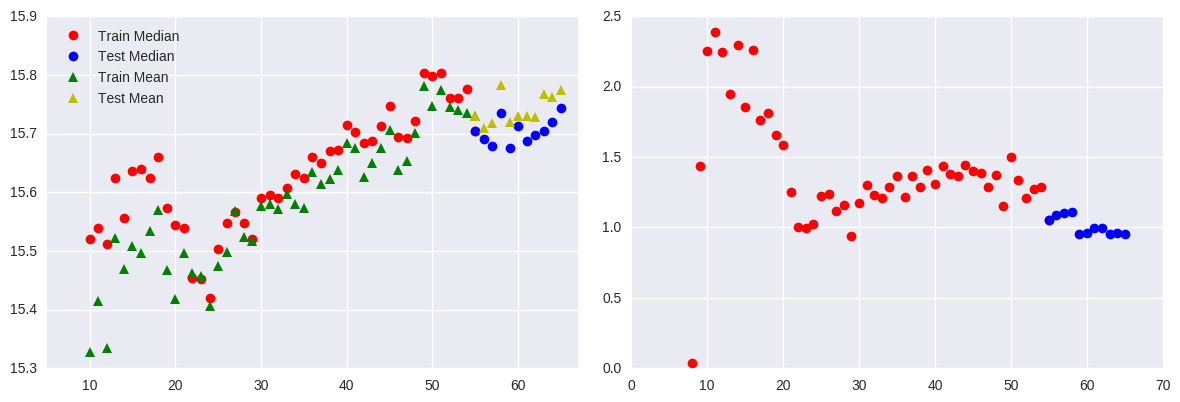

In [258]:
# read naive xgboost
pred = pd.read_csv("naivexgb.csv")

tt = data[:]
tt = tt[["time_month", "time_week"]]
yy = pd.concat([ylog, pred['price_doc'].apply(np.log)], axis=0)
tt['price'] = yy
tt['time_month'] = tt["time_month"].apply(str)
price_median = tt.groupby('time_month')['price'].aggregate(np.median).reset_index()
price_mean = tt.groupby('time_month')['price'].aggregate(np.mean).reset_index()
price_q1 = tt.groupby('time_month')['price'].aggregate(lambda x: np.percentile(x,10)).reset_index()
price_q3 = tt.groupby('time_month')['price'].aggregate(lambda x: np.percentile(x,90)).reset_index()

price_q1["delta"] = price_q3["price"] - price_q1["price"]

price_median["time_month"] = price_median["time_month"].apply(int)
price_median = price_median.sort_values(by="time_month")

price_mean["time_month"] = price_mean["time_month"].apply(int)
price_mean = price_mean.sort_values(by="time_month")

price_q1["time_month"] = price_q1["time_month"].apply(int)
price_q1 = price_q1.sort_values(by="time_month")

fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
fig.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.94, wspace=0.1)

axs[0].plot(price_median.loc[0:45, "time_month"], price_median.loc[0:45, "price"], 'ro', label='Train Median')
axs[0].plot(price_median.loc[45:, "time_month"], price_median.loc[45:, "price"], 'bo', label='Test Median')
axs[0].plot(price_mean.loc[0:45, "time_month"], price_mean.loc[0:45, "price"], 'g^', label='Train Mean')
axs[0].plot(price_mean.loc[45:, "time_month"], price_mean.loc[45:, "price"], 'y^', label='Test Mean')
axs[0].set_xlim([5,67])

axs[0].legend(loc='upper left')

axs[1].plot(price_q1.loc[:45, "time_month"], price_q1.loc[:45, "delta"], 'ro')
axs[1].plot(price_q1.loc[45:, "time_month"], price_q1.loc[45:, "delta"], 'bo')

In [201]:
pred['price_doc'].apply(np.log).describe()


count    7662.000000
mean       15.739644
std         0.404946
min        14.350297
25%        15.488691
50%        15.699180
75%        15.960903
max        18.002861
Name: price_doc, dtype: float64